
CAR MODIFICATION STUDIO MANAGEMENT SYSTEM

                                   MAIN MENU                                    

Please select an option:
1. Customer Login
2. Customer Registration
3. Admin Dashboard
4. View Income Graphs (Demo)
5. Exit
0. Exit/Go Back



Enter your choice:  3



                                ADMIN DASHBOARD                                 
Total Customers: 1
Total Bills: 1
Total Revenue: $253,936.00
Available Modifications: 20
Active Appointments: 0

Recent Bills:
------------------------------------------------------------
Bill #1: 2026-01-01 10:10:48 - $253,936.00 - Fenil - Volvo XC 90

------------------------------------------------------------
ADMIN ANALYTICS OPTIONS
------------------------------------------------------------
1. Generate Income Analysis Graphs
2. Generate Detailed Admin Dashboard
3. Back to Main Menu



Select option (1-3):  2



                             ADMIN INCOME ANALYTICS                             


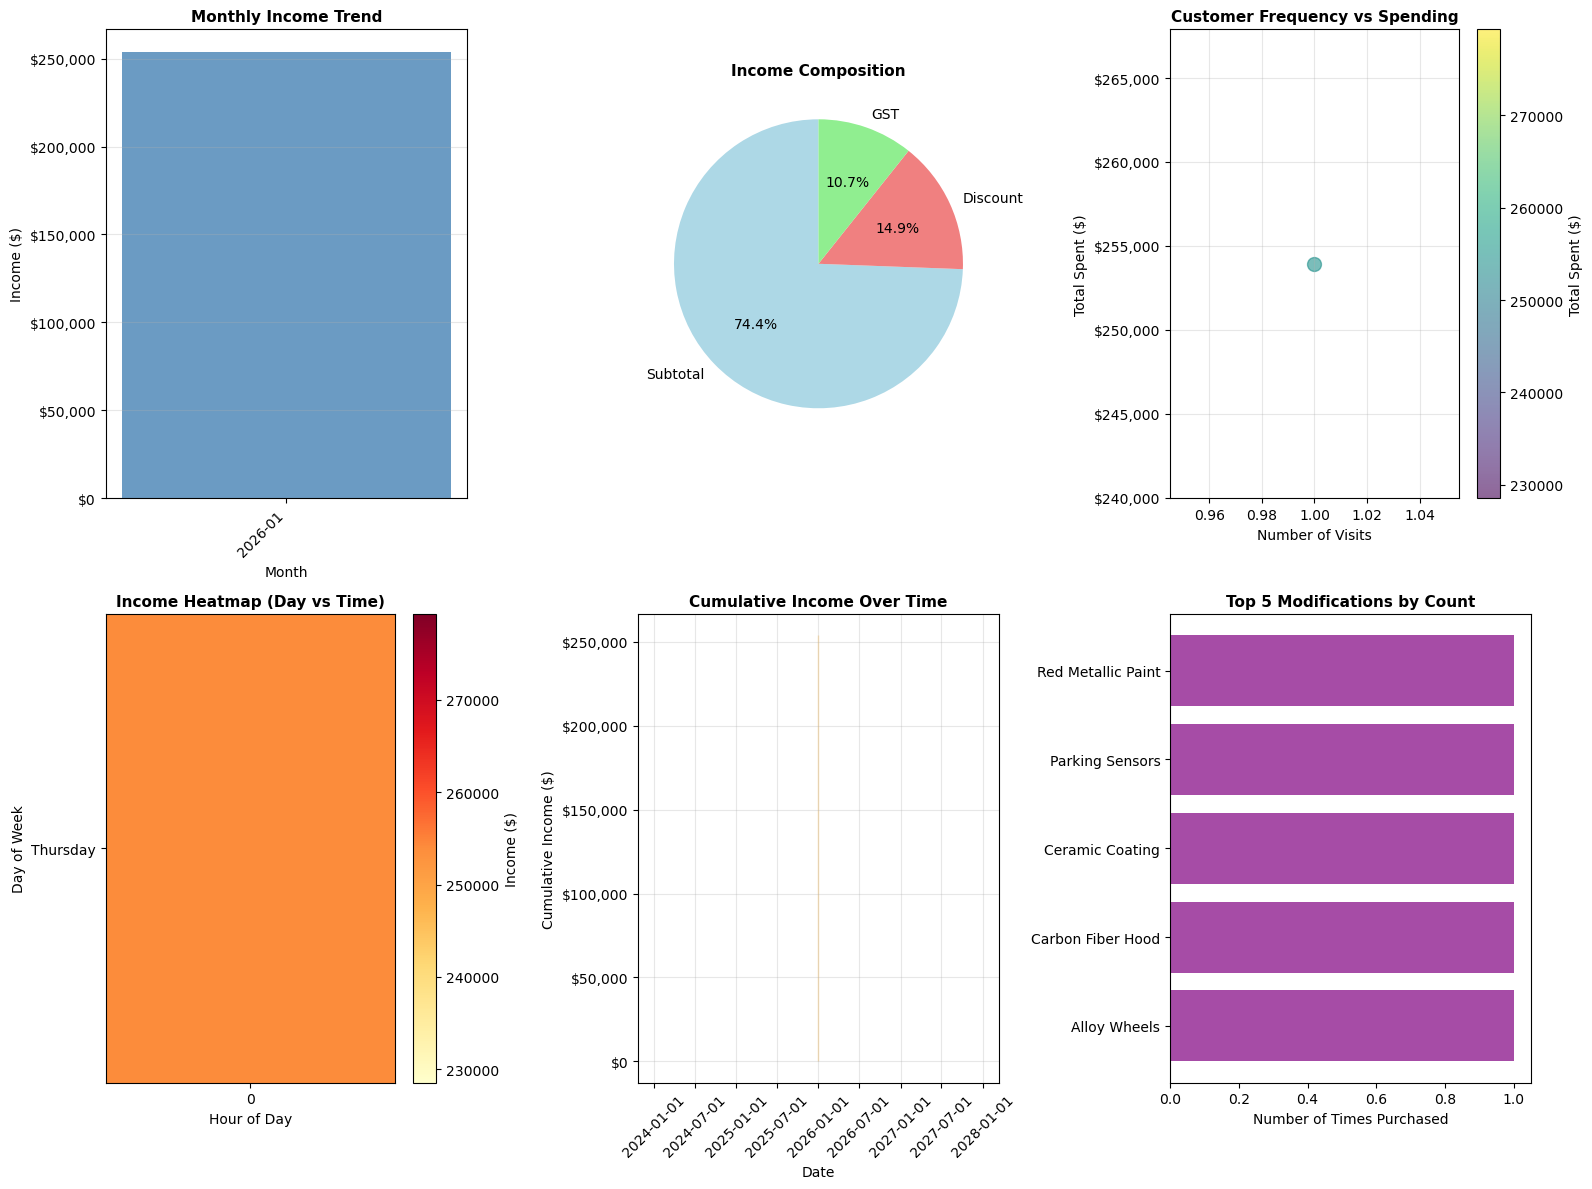


Admin dashboard saved to: graphs/admin/admin_dashboard_20260108_210347.png

DETAILED INCOME ANALYTICS

Period: 2026-01-01 to 2026-01-01
Total Revenue: $253,936.00
Average Bill Amount: $253,936.00
Total Discounts Given: $53,800.00
Total GST Collected: $38,736.00

Customer Insights:
  - Total Unique Customers: 1
  - Most Frequent Customer: Fenil
  - Highest Single Bill: $253,936.00
  - Average Visits per Customer: 1.0



Press Enter to continue... 



                                   MAIN MENU                                    

Please select an option:
1. Customer Login
2. Customer Registration
3. Admin Dashboard
4. View Income Graphs (Demo)
5. Exit
0. Exit/Go Back



Enter your choice:  4



                             INCOME ANALYSIS GRAPHS                             
Analyzing 1 income records...
Time period: 2026-01-01 to 2026-01-01
Total customers: 1


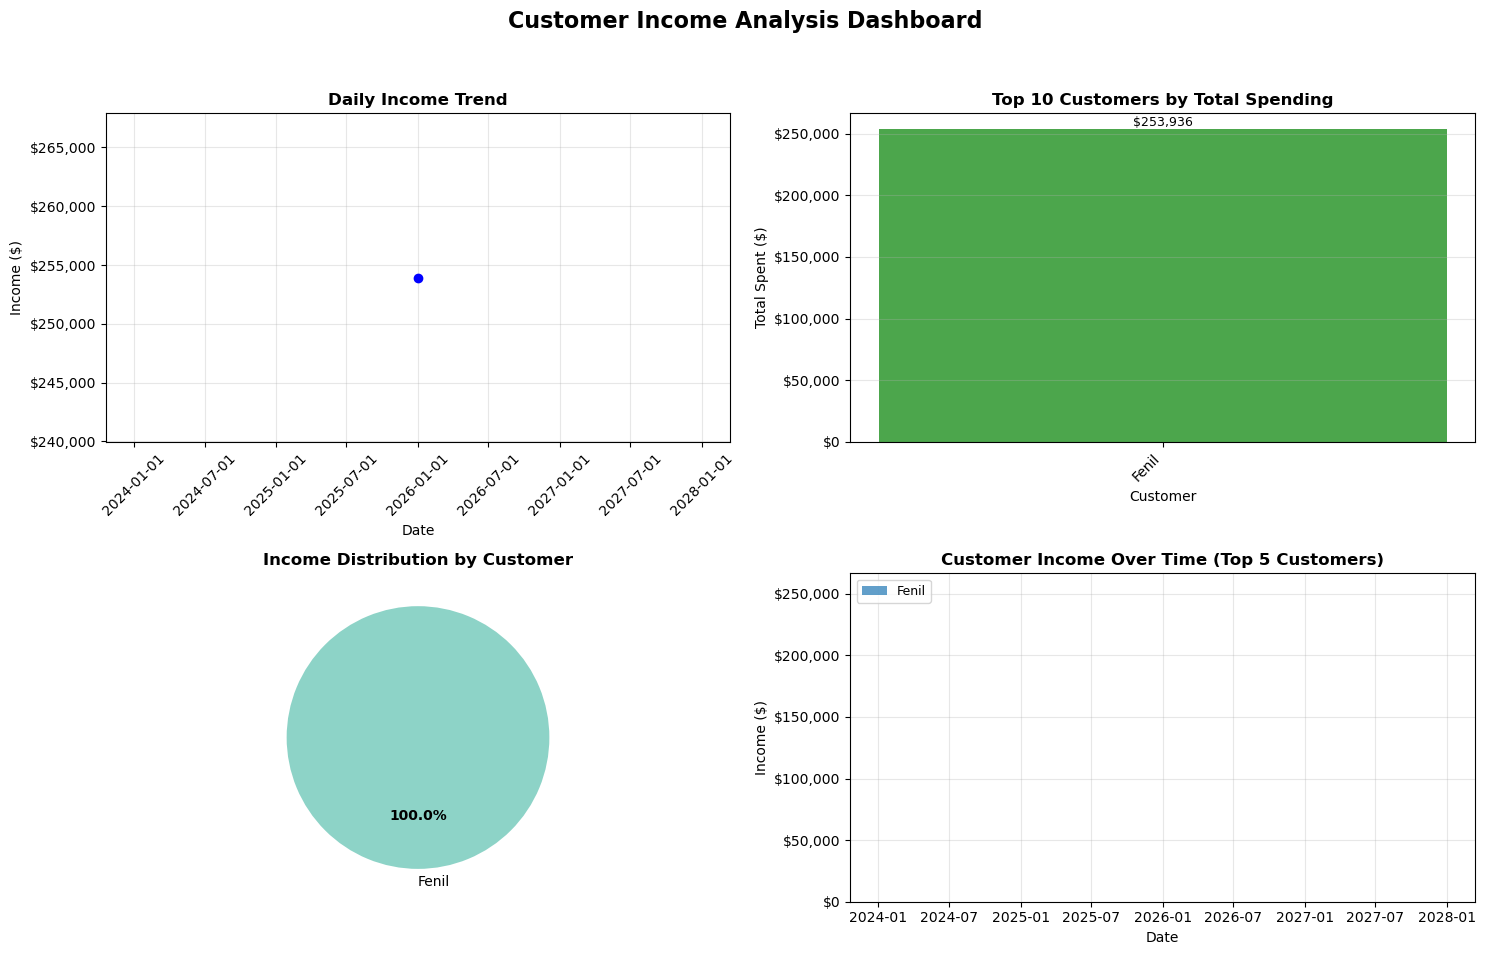


Graphs saved to: graphs/income_analysis_20260108_210419.png

INCOME SUMMARY STATISTICS
Total Income Period: $253,936.00
Average Daily Income: $253,936.00
Top Customer: Fenil ($253,936.00)
Number of Billing Days: 1
Total Bills: 1

Customer Segmentation by Spending:
  VIP (>$20k): 1 customers
  Small (<$1k): 0 customers
  Medium ($1k-5k): 0 customers
  Large ($5k-20k): 0 customers



Press Enter to continue... 



                                   MAIN MENU                                    

Please select an option:
1. Customer Login
2. Customer Registration
3. Admin Dashboard
4. View Income Graphs (Demo)
5. Exit
0. Exit/Go Back


In [ ]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta
import uuid
import os
import sys
import json
import hashlib
import warnings
import re  # Added import
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Constants
GST_RATE = 0.18
DB_NAME = "car_mod.db"

# Database connection helper
def get_db_connection():
    conn = sqlite3.connect(DB_NAME)
    conn.row_factory = sqlite3.Row
    return conn

# Initialize database with all tables
def initialize_database():
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # Create customers table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS customers (
        email TEXT PRIMARY KEY,
        name TEXT NOT NULL,
        phone TEXT,
        address TEXT,
        city TEXT,
        state TEXT,
        pincode TEXT,
        total_visits INTEGER DEFAULT 0,
        total_spent REAL DEFAULT 0,
        loyalty_points INTEGER DEFAULT 0,
        first_visit TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        last_visit TIMESTAMP,
        referral_code TEXT
    )
    ''')
    
    # Create cars table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS cars (
        car_id INTEGER PRIMARY KEY AUTOINCREMENT,
        customer_email TEXT NOT NULL,
        car_model TEXT NOT NULL,
        car_make TEXT,
        car_year INTEGER,
        car_color TEXT,
        FOREIGN KEY (customer_email) REFERENCES customers(email)
    )
    ''')
    
    # Create modifications table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS modifications (
        mod_id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        price REAL NOT NULL,
        category TEXT NOT NULL,
        description TEXT,
        is_active INTEGER DEFAULT 1
    )
    ''')
    
    # Create bills table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS bills (
        bill_id TEXT PRIMARY KEY,
        customer_email TEXT NOT NULL,
        car_id INTEGER,
        bill_date TIMESTAMP,
        bill_number INTEGER,
        subtotal REAL,
        discount REAL,
        discount_percent REAL,
        gst REAL,
        gst_rate REAL,
        total REAL,
        payment_method TEXT,
        notes TEXT,
        FOREIGN KEY (customer_email) REFERENCES customers(email),
        FOREIGN KEY (car_id) REFERENCES cars(car_id)
    )
    ''')
    
    # Create bill_items table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS bill_items (
        item_id INTEGER PRIMARY KEY AUTOINCREMENT,
        bill_id TEXT NOT NULL,
        mod_id INTEGER,
        mod_name TEXT NOT NULL,
        mod_category TEXT NOT NULL,
        price REAL,
        total_price REAL,
        FOREIGN KEY (bill_id) REFERENCES bills(bill_id)
    )
    ''')
    
    # Create appointments table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS appointments (
        appointment_id INTEGER PRIMARY KEY AUTOINCREMENT,
        customer_email TEXT NOT NULL,
        car_id INTEGER,
        appointment_date DATE,
        appointment_time TIME,
        service_type TEXT,
        notes TEXT,
        status TEXT DEFAULT 'Scheduled',
        FOREIGN KEY (customer_email) REFERENCES customers(email),
        FOREIGN KEY (car_id) REFERENCES cars(car_id)
    )
    ''')
    
    # Insert sample modifications if empty
    cursor.execute("SELECT COUNT(*) FROM modifications")
    if cursor.fetchone()[0] == 0:
        sample_mods = [
            ("Turbocharger Kit", 50000, "Performance", "Increase engine power by 40%"),
            ("ECU Remap", 20000, "Performance", "Optimize engine performance"),
            ("Sports Suspension", 30000, "Performance", "Improved handling and stability"),
            ("Premium Leather Seats", 45000, "Comfort", "Full leather interior upgrade"),
            ("Premium Sound System", 35000, "Technology", "High-end audio system"),
            ("LED Headlights", 15000, "Aesthetic", "Bright LED headlight kit"),
            ("Ceramic Coating", 25000, "Aesthetic", "Paint protection coating"),
            ("Red Metallic Paint", 30000, "Color", "Premium metallic red color"),
            ("Blue Pearl Paint", 32000, "Color", "Pearl finish blue color"),
            ("Black Matte Paint", 35000, "Color", "Matte black finish"),
            ("Performance Exhaust", 28000, "Performance", "Enhanced exhaust system"),
            ("Carbon Fiber Hood", 40000, "Aesthetic", "Lightweight carbon fiber hood"),
            ("Sunroof", 35000, "Comfort", "Electric sunroof installation"),
            ("Backup Camera", 12000, "Technology", "Rear view camera system"),
            ("Parking Sensors", 8000, "Technology", "Front and rear parking sensors"),
            ("Alloy Wheels", 25000, "Aesthetic", "18-inch alloy wheels"),
            ("Window Tinting", 7000, "Aesthetic", "Premium window tinting"),
            ("Dash Cam", 5000, "Technology", "Front and rear dash camera"),
            ("Ambient Lighting", 9000, "Aesthetic", "Interior ambient lighting"),
            ("Remote Start", 11000, "Technology", "Keyless remote start system")
        ]
        cursor.executemany("INSERT INTO modifications (name, price, category, description) VALUES (?, ?, ?, ?)", sample_mods)
    
    conn.commit()
    conn.close()

# Utility functions
def valid_email(email):
    return bool(re.match(r"^[\w\.-]+@[\w\.-]+\.\w+$", email))

def valid_phone(phone):
    return bool(re.match(r"^\+?[0-9\s\-]{10,15}$", phone))

def safe_text(text):
    return re.sub(r"[^A-Za-z0-9]", "_", text)

def hash_password(password):
    return hashlib.sha256(password.encode()).hexdigest()

def calculate_totals(mods, color, customer_email=None):
    """Calculate subtotal, discounts, GST, and total"""
    subtotal = 0
    
    for mod in mods:
        subtotal += mod['price']
    
    if color:
        subtotal += color['price']
    
    discount_percent = 0
    discount_amount = 0
    
    # Volume discount
    if len(mods) >= 5:
        discount_percent += 15
    elif len(mods) >= 3:
        discount_percent += 10
    
    # Loyalty discount
    if customer_email:
        conn = get_db_connection()
        cursor = conn.cursor()
        cursor.execute("SELECT total_visits, loyalty_points FROM customers WHERE email = ?", (customer_email,))
        customer = cursor.fetchone()
        conn.close()
        
        if customer:
            if customer['total_visits'] > 5:
                discount_percent += 10
            elif customer['total_visits'] > 1:
                discount_percent += 5
    
    # Festival discount
    current_month = datetime.now().month
    festival_months = [1, 10, 12]
    if current_month in festival_months:
        discount_percent += 5
    
    discount_percent = min(discount_percent, 30)
    
    if discount_percent > 0:
        discount_amount = subtotal * (discount_percent / 100)
        subtotal -= discount_amount
    
    gst = subtotal * GST_RATE
    total = subtotal + gst
    
    return {
        'subtotal': subtotal + discount_amount,
        'discount_percent': discount_percent,
        'discount_amount': discount_amount,
        'subtotal_after_discount': subtotal,
        'gst': gst,
        'total': total
    }

# AI Recommendation Engine
class AIRecommendationEngine:
    def __init__(self):
        self.conn = get_db_connection()
        
    def get_personalized_recommendations(self, user_email, limit=5):
        """Get AI-powered personalized recommendations"""
        cursor = self.conn.cursor()
        
        # Get user preferences from purchase history
        cursor.execute("""
            SELECT bi.mod_category, COUNT(*) as frequency, 
                   AVG(bi.price) as avg_spent
            FROM bill_items bi
            JOIN bills b ON bi.bill_id = b.bill_id
            WHERE b.customer_email = ?
            GROUP BY bi.mod_category
        """, (user_email,))
        user_prefs = cursor.fetchall()
        
        # Get car info
        cursor.execute("SELECT car_model, car_make, car_year FROM cars WHERE customer_email = ? LIMIT 1", (user_email,))
        car_info = cursor.fetchone()
        
        # Get all active modifications
        cursor.execute("SELECT mod_id, name, price, category, description FROM modifications WHERE is_active = 1")
        all_mods = cursor.fetchall()
        
        recommendations = []
        for mod in all_mods:
            score = 50  # Base score
            
            # 1. Category preference boost
            for pref in user_prefs:
                if pref['mod_category'] == mod['category']:
                    score += pref['frequency'] * 5
            
            # 2. Price range suitability
            if user_prefs:
                total_spent = sum(p['avg_spent'] for p in user_prefs)
                avg_spent = total_spent / len(user_prefs) if user_prefs else 0
                
                if avg_spent > 0:
                    price_ratio = mod['price'] / (avg_spent * 1.5)
                    if 0.5 <= price_ratio <= 1.5:
                        score += 20
                    elif price_ratio < 0.5:
                        score += 10
                    else:
                        score -= 10
            
            # 3. Car model compatibility
            if car_info:
                car_year = car_info['car_year'] or datetime.now().year
                car_age = datetime.now().year - car_year
                
                # Performance mods for newer cars
                if mod['category'] == 'Performance' and car_age < 5:
                    score += 10
                
                # Safety mods for older cars
                if mod['category'] == 'Safety' and car_age > 5:
                    score += 10
            
            # Only recommend if score >= 60
            if score >= 60:
                recommendations.append({
                    'mod_id': mod['mod_id'],
                    'name': mod['name'],
                    'category': mod['category'],
                    'price': mod['price'],
                    'ai_score': min(score, 100),
                    'description': mod['description']
                })
        
        # Sort by AI score and return top N
        recommendations.sort(key=lambda x: x['ai_score'], reverse=True)
        return recommendations[:limit]
    
    def get_recommendation_reason(self, mod, user_prefs, car_info, score):
        """Generate reason for recommendation"""
        reasons = []
        
        for pref in user_prefs:
            if pref['mod_category'] == mod['category']:
                reasons.append(f"Matches your preference for {mod['category']} modifications")
                break
        
        if mod['price'] < 1000:
            reasons.append("Budget-friendly option")
        elif mod['price'] > 3000:
            reasons.append("Premium upgrade for enhanced experience")
        
        if car_info:
            if mod['category'] == 'Performance' and (car_info['car_year'] or 0) > 2020:
                reasons.append("Ideal for newer car models")
        
        return " | ".join(reasons[:2]) if reasons else "Great value addition"
    
    def __del__(self):
        self.conn.close()

# Modification Risk Calculator
class ModificationRiskCalculator:
    """Calculate risk score for modifications (1-10 scale)"""
    
    RISK_FACTORS = {
        'warranty_void': 3.0,
        'insurance_impact': 2.5,
        'installation_complexity': 2.0,
        'maintenance_cost': 1.5,
        'resale_impact': 1.0,
        'legal_compliance': 3.0
    }
    
    @staticmethod
    def calculate_modification_risk(modification_data, car_data):
        """Calculate overall risk score (1-10)"""
        risk_scores = []
        
        # 1. Warranty Risk
        warranty_risk = ModificationRiskCalculator._calculate_warranty_risk(
            modification_data['category'], 
            car_data.get('car_year', datetime.now().year) if isinstance(car_data, dict) else (car_data['car_year'] if car_data and car_data['car_year'] else datetime.now().year)
        )
        risk_scores.append(warranty_risk * ModificationRiskCalculator.RISK_FACTORS['warranty_void'])
        
        # 2. Insurance Impact
        insurance_risk = ModificationRiskCalculator._calculate_insurance_risk(
            modification_data['category'], 
            modification_data.get('price', 0)
        )
        risk_scores.append(insurance_risk * ModificationRiskCalculator.RISK_FACTORS['insurance_impact'])
        
        # 3. Installation Complexity
        complexity_risk = ModificationRiskCalculator._calculate_complexity_risk(
            modification_data['category']
        )
        risk_scores.append(complexity_risk * ModificationRiskCalculator.RISK_FACTORS['installation_complexity'])
        
        # 4. Maintenance Cost Impact
        maintenance_risk = ModificationRiskCalculator._calculate_maintenance_risk(
            modification_data['category']
        )
        risk_scores.append(maintenance_risk * ModificationRiskCalculator.RISK_FACTORS['maintenance_cost'])
        
        # 5. Resale Value Impact
        resale_risk = ModificationRiskCalculator._calculate_resale_risk(
            modification_data['category'], 
            car_data.get('car_make', '') if isinstance(car_data, dict) else (car_data['car_make'] if car_data else '')
        )
        risk_scores.append(resale_risk * ModificationRiskCalculator.RISK_FACTORS['resale_impact'])
        
        # 6. Legal Compliance
        legal_risk = ModificationRiskCalculator._calculate_legal_risk(
            modification_data['category'], 
            car_data.get('car_year', datetime.now().year) if isinstance(car_data, dict) else (car_data['car_year'] if car_data and car_data['car_year'] else datetime.now().year)
        )
        risk_scores.append(legal_risk * ModificationRiskCalculator.RISK_FACTORS['legal_compliance'])
        
        # Calculate weighted average
        total_weight = sum(ModificationRiskCalculator.RISK_FACTORS.values())
        weighted_risk = sum(risk_scores) / total_weight
        
        # Normalize to 1-10 scale
        normalized_risk = min(max(weighted_risk * 2, 1), 10)
        
        return round(normalized_risk, 1)
    
    @staticmethod
    def _calculate_warranty_risk(mod_category, car_year):
        """Calculate warranty void risk (0-5 scale)"""
        warranty_risks = {
            'Performance': 4.5 if car_year < 3 else 3.0,
            'Technology': 2.0,
            'Safety': 1.0,
            'Comfort': 1.5,
            'Aesthetic': 0.5,
            'Color': 0.1
        }
        return warranty_risks.get(mod_category, 2.0)
    
    @staticmethod
    def _calculate_insurance_risk(mod_category, price):
        """Calculate insurance premium impact (0-5 scale)"""
        if price > 50000:
            risk = 4.0
        elif price > 20000:
            risk = 3.0
        elif price > 5000:
            risk = 2.0
        else:
            risk = 1.0
        
        # Category adjustments
        if mod_category == 'Performance':
            risk += 1.0
        elif mod_category == 'Safety':
            risk -= 0.5
        
        return min(max(risk, 0), 5)
    
    @staticmethod
    def _calculate_complexity_risk(mod_category):
        """Calculate installation complexity (0-5 scale)"""
        complexity = {
            'Performance': 4.0,
            'Technology': 3.5,
            'Safety': 3.0,
            'Comfort': 2.5,
            'Aesthetic': 2.0,
            'Color': 1.5
        }
        return complexity.get(mod_category, 2.5)
    
    @staticmethod
    def _calculate_maintenance_risk(mod_category):
        """Calculate maintenance cost impact (0-5 scale)"""
        maintenance = {
            'Performance': 3.5,
            'Technology': 3.0,
            'Safety': 2.0,
            'Comfort': 2.5,
            'Aesthetic': 1.5,
            'Color': 1.0
        }
        return maintenance.get(mod_category, 2.0)
    
    @staticmethod
    def _calculate_resale_risk(mod_category, car_make):
        """Calculate resale value impact (0-5 scale)"""
        premium_brands = ['Mercedes', 'BMW', 'Audi', 'Porsche', 'Lexus']
        is_premium = any(brand.lower() in str(car_make).lower() for brand in premium_brands)
        
        resale_impact = {
            'Performance': 2.5 if is_premium else 3.5,
            'Technology': 2.0,
            'Safety': 1.0,
            'Comfort': 1.5,
            'Aesthetic': 3.0 if is_premium else 2.0,
            'Color': 4.0
        }
        return resale_impact.get(mod_category, 2.5)
    
    @staticmethod
    def _calculate_legal_risk(mod_category, car_year):
        """Calculate legal compliance risk (0-5 scale)"""
        legal_risks = {
            'Performance': 3.5 if car_year < 10 else 4.0,
            'Technology': 1.0,
            'Safety': 0.5,
            'Comfort': 1.0,
            'Aesthetic': 2.0,
            'Color': 3.0
        }
        return legal_risks.get(mod_category, 2.0)
    
    @staticmethod
    def get_risk_interpretation(risk_score):
        """Interpret the risk score"""
        if risk_score <= 3:
            return {
                "level": "Low Risk",
                "description": "Safe modification with minimal impact",
                "recommendation": "Recommended for all users"
            }
        elif risk_score <= 6:
            return {
                "level": "Medium Risk",
                "description": "Moderate impact on warranty/insurance",
                "recommendation": "Consult with our experts before proceeding"
            }
        else:
            return {
                "level": "High Risk",
                "description": "Significant impact on warranty, insurance, and legality",
                "recommendation": "Professional consultation mandatory"
            }

# Customer Classification System
class CustomerClassifier:
    """Automatically classify customers into types"""
    
    CUSTOMER_TYPES = {
        0: {
            "name": "Performance Seeker",
            "description": "Focuses on speed, power, and handling improvements",
            "preferred_categories": ["Performance", "Safety"],
            "avg_spend_range": "High ($50,000+)",
            "typical_mods": ["Turbocharger", "ECU Remap", "Sports Suspension"]
        },
        1: {
            "name": "Daily Comfort",
            "description": "Prioritizes comfort, convenience, and reliability",
            "preferred_categories": ["Comfort", "Technology"],
            "avg_spend_range": "Medium ($20,000-$50,000)",
            "typical_mods": ["Premium Seats", "Climate Control", "Audio System"]
        },
        2: {
            "name": "Luxury / Aesthetic",
            "description": "Focuses on looks, luxury features, and visual appeal",
            "preferred_categories": ["Aesthetic", "Color", "Comfort"],
            "avg_spend_range": "High ($50,000+)",
            "typical_mods": ["Custom Paint", "Body Kits", "Leather Interior"]
        }
    }
    
    def __init__(self):
        self.conn = get_db_connection()
        
    def extract_customer_features(self, customer_email):
        """Extract features for classification"""
        cursor = self.conn.cursor()
        
        features = {}
        
        # 1. Spending patterns
        cursor.execute("""
            SELECT 
                COUNT(DISTINCT b.bill_id) as total_orders,
                SUM(b.total) as total_spent,
                AVG(b.total) as avg_order_value
            FROM bills b
            WHERE b.customer_email = ?
        """, (customer_email,))
        
        spending = cursor.fetchone()
        features['total_orders'] = spending['total_orders'] or 0
        features['total_spent'] = spending['total_spent'] or 0
        features['avg_order_value'] = spending['avg_order_value'] or 0
        
        # 2. Category preferences
        cursor.execute("""
            SELECT 
                bi.mod_category,
                COUNT(*) as mod_count,
                SUM(bi.total_price) as category_spent
            FROM bill_items bi
            JOIN bills b ON bi.bill_id = b.bill_id
            WHERE b.customer_email = ?
            GROUP BY bi.mod_category
        """, (customer_email,))
        
        categories = cursor.fetchall()
        
        # Initialize category features
        all_categories = ['Performance', 'Aesthetic', 'Technology', 'Safety', 'Comfort', 'Color']
        for cat in all_categories:
            features[f'cat_{cat.lower()}_count'] = 0
            features[f'cat_{cat.lower()}_spent'] = 0
        
        # Fill category data
        for cat in categories:
            cat_name = cat['mod_category'].lower()
            features[f'cat_{cat_name}_count'] = cat['mod_count']
            features[f'cat_{cat_name}_spent'] = cat['category_spent']
        
        return features
    
    def classify_customer(self, customer_email):
        """Classify customer using rule-based system"""
        features = self.extract_customer_features(customer_email)
        
        # Rule-based classification
        total_spent = features.get('total_spent', 0)
        if total_spent == 0:
            return self.CUSTOMER_TYPES[1]  # Default to Daily Comfort for new customers
        
        performance_ratio = features.get('cat_performance_spent', 0) / total_spent
        aesthetic_ratio = features.get('cat_aesthetic_spent', 0) / total_spent
        comfort_ratio = features.get('cat_comfort_spent', 0) / total_spent
        
        # Determine dominant preference
        if performance_ratio > 0.4:
            return self.CUSTOMER_TYPES[0]  # Performance Seeker
        elif aesthetic_ratio > 0.3:
            return self.CUSTOMER_TYPES[2]  # Luxury/Aesthetic
        else:
            return self.CUSTOMER_TYPES[1]  # Daily Comfort
    
    def get_recommendations_for_type(self, customer_type_idx):
        """Get modification recommendations based on customer type"""
        recommendations = {
            0: {  # Performance Seeker
                "must_have": ["Turbocharger Kit", "Performance Exhaust", "Sports Suspension"],
                "recommended": ["ECU Remap", "Advanced Brake System", "Lightweight Wheels"],
                "budget_friendly": ["Air Intake System", "Performance Chip", "Strut Bar"]
            },
            1: {  # Daily Comfort
                "must_have": ["Premium Leather Seats", "Premium Sound System", "Sunroof"],
                "recommended": ["Climate Control", "Noise Insulation", "Backup Camera"],
                "budget_friendly": ["Seat Covers", "Steering Wheel Cover", "Car Organizer"]
            },
            2: {  # Luxury / Aesthetic
                "must_have": ["Ceramic Coating", "Custom Paint Job", "LED Headlight Kit"],
                "recommended": ["Body Kit", "Carbon Fiber Hood", "Ambient Lighting"],
                "budget_friendly": ["Window Tinting", "Alloy Wheel Covers", "Dash Cam"]
            }
        }
        
        return recommendations.get(customer_type_idx, recommendations[1])
    
    def __del__(self):
        self.conn.close()

# Console Interface Functions
def display_header(title):
    print("\n" + "="*80)
    print(f"{title:^80}")
    print("="*80)

def display_menu(options):
    print("\nPlease select an option:")
    for i, (option, _) in enumerate(options, 1):
        print(f"{i}. {option}")
    print("0. Exit/Go Back")
    
    while True:
        try:
            choice = int(input("\nEnter your choice: "))
            if 0 <= choice <= len(options):
                return choice
            else:
                print(f"Please enter a number between 0 and {len(options)}")
        except ValueError:
            print("Please enter a valid number")

def register_customer():
    display_header("NEW CUSTOMER REGISTRATION")
    
    while True:
        name = input("Full Name: ").strip()
        if name:
            break
        print("Name is required!")
    
    while True:
        email = input("Email: ").strip()
        if valid_email(email):
            break
        print("Invalid email format!")
    
    phone = input("Phone (optional): ").strip()
    if phone and not valid_phone(phone):
        print("Warning: Phone number format may be invalid")
    
    address = input("Address (optional): ").strip()
    city = input("City (optional): ").strip()
    state = input("State (optional): ").strip()
    pincode = input("Pincode (optional): ").strip()
    
    conn = get_db_connection()
    cursor = conn.cursor()
    
    try:
        cursor.execute("""
            INSERT INTO customers (email, name, phone, address, city, state, pincode) 
            VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (email, name, phone, address, city, state, pincode))
        conn.commit()
        print(f"\nRegistration successful! Welcome {name}!")
        return email
    except sqlite3.IntegrityError:
        print("\nEmail already registered! Please login instead.")
        return None
    finally:
        conn.close()

def login_customer():
    display_header("CUSTOMER LOGIN")
    
    email = input("Email: ").strip()
    
    if not valid_email(email):
        print("Invalid email format!")
        return None
    
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM customers WHERE email = ?", (email,))
    customer = cursor.fetchone()
    conn.close()
    
    if customer:
        print(f"\nWelcome back, {customer['name']}!")
        return email
    else:
        print("\nCustomer not found. Please register first.")
        return None

def add_car(customer_email):
    display_header("ADD NEW CAR")
    
    while True:
        car_model = input("Car Model*: ").strip()
        if car_model:
            break
        print("Car Model is required!")
    
    car_make = input("Car Make (optional): ").strip()
    
    while True:
        car_year = input("Year (optional, press Enter to skip): ").strip()
        if not car_year:
            car_year = None
            break
        try:
            car_year = int(car_year)
            if 1900 <= car_year <= datetime.now().year + 1:
                break
            print(f"Year must be between 1900 and {datetime.now().year + 1}")
        except ValueError:
            print("Please enter a valid year")
    
    car_color = input("Current Color (optional): ").strip()
    
    conn = get_db_connection()
    cursor = conn.cursor()
    
    try:
        cursor.execute("""
            INSERT INTO cars (customer_email, car_model, car_make, car_year, car_color) 
            VALUES (?, ?, ?, ?, ?)
        """, (customer_email, car_model, car_make, car_year, car_color))
        conn.commit()
        print(f"\nCar '{car_model}' added successfully!")
    except Exception as e:
        print(f"\nError: {e}")
    finally:
        conn.close()

def list_cars(customer_email):
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute("""
        SELECT car_id, car_model, car_make, car_year, car_color 
        FROM cars 
        WHERE customer_email = ?
        ORDER BY car_year DESC
    """, (customer_email,))
    cars = cursor.fetchall()
    conn.close()
    
    if cars:
        display_header("YOUR CARS")
        print(f"{'ID':<5} {'Model':<20} {'Make':<15} {'Year':<8} {'Color':<15}")
        print("-"*70)
        for car in cars:
            print(f"{car['car_id']:<5} {car['car_model']:<20} {car['car_make'] or 'N/A':<15} "
                  f"{car['car_year'] or 'N/A':<8} {car['car_color'] or 'N/A':<15}")
        return cars
    else:
        print("\nNo cars found. Please add a car first.")
        return []

def list_modifications():
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute("""
        SELECT mod_id, name, price, category, description 
        FROM modifications 
        WHERE is_active = 1 
        ORDER BY category, price DESC
    """)
    mods = cursor.fetchall()
    conn.close()
    
    display_header("AVAILABLE MODIFICATIONS")
    
    categories = {}
    for mod in mods:
        category = mod['category']
        if category not in categories:
            categories[category] = []
        categories[category].append(mod)
    
    for category, mods_list in categories.items():
        print(f"\n{category.upper()}:")
        print("-"*80)
        for mod in mods_list:
            print(f"ID: {mod['mod_id']:3d} | ${mod['price']:8,.2f} | {mod['name']:30} | "
                  f"{mod['description'] or 'No description'}")
    
    return mods

def select_modifications():
    all_mods = list_modifications()
    selected_mods = []
    
    while True:
        try:
            mod_id = int(input("\nEnter modification ID to add (0 to finish): "))
            
            if mod_id == 0:
                break
            
            selected_mod = next((mod for mod in all_mods if mod['mod_id'] == mod_id), None)
            if selected_mod:
                selected_mods.append({
                    'mod_id': selected_mod['mod_id'],
                    'name': selected_mod['name'],
                    'price': selected_mod['price'],
                    'category': selected_mod['category']
                })
                print(f"Added: {selected_mod['name']}")
            else:
                print("Invalid modification ID!")
        except ValueError:
            print("Please enter a valid number")
    
    return selected_mods

def create_build(customer_email):
    display_header("CREATE NEW BUILD")
    
    # List and select car
    cars = list_cars(customer_email)
    if not cars:
        return
    
    while True:
        try:
            car_choice = int(input("\nSelect car ID: "))
            selected_car = next((car for car in cars if car['car_id'] == car_choice), None)
            if selected_car:
                break
            print("Invalid car selection!")
        except ValueError:
            print("Please enter a valid number")
    
    # Select modifications
    selected_mods = select_modifications()
    
    if not selected_mods:
        print("\nNo modifications selected!")
        return
    
    # Calculate totals
    totals = calculate_totals(selected_mods, None, customer_email)
    
    # Display summary
    display_header("BUILD SUMMARY")
    print(f"Car: {selected_car['car_model']}")
    
    print("\nSelected Modifications:")
    for mod in selected_mods:
        print(f"  • {mod['name']} - ${mod['price']:,.2f}")
    
    print(f"\nSubtotal: ${totals['subtotal']:,.2f}")
    if totals['discount_percent'] > 0:
        print(f"Discount ({totals['discount_percent']}%): -${totals['discount_amount']:,.2f}")
        print(f"After Discount: ${totals['subtotal_after_discount']:,.2f}")
    print(f"GST ({GST_RATE*100}%): ${totals['gst']:,.2f}")
    print(f"Total: ${totals['total']:,.2f}")
    
    # Loyalty points info
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute("SELECT loyalty_points FROM customers WHERE email = ?", (customer_email,))
    loyalty_points = cursor.fetchone()['loyalty_points']
    conn.close()
    
    points_to_earn = int(totals['total'] / 100)
    print(f"\nLoyalty Points:")
    print(f"  Current: {loyalty_points}")
    print(f"  To earn: {points_to_earn}")
    print(f"  Total after purchase: {loyalty_points + points_to_earn}")
    
    # Confirm purchase
    confirm = input("\nComplete purchase? (yes/no): ").strip().lower()
    if confirm in ['yes', 'y']:
        save_bill(customer_email, selected_car['car_id'], selected_mods, None, totals)
        print("\nPurchase completed successfully!")
    else:
        print("\nPurchase cancelled.")

def save_bill(customer_email, car_id, mods, color, totals):
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # Generate bill ID and number
    bill_id = f"BILL-{datetime.now().strftime('%Y%m%d')}-{str(uuid.uuid4())[:6].upper()}"
    bill_date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    cursor.execute("SELECT MAX(bill_number) FROM bills")
    result = cursor.fetchone()[0]
    bill_number = (result or 0) + 1
    
    # Get customer name
    cursor.execute("SELECT name FROM customers WHERE email = ?", (customer_email,))
    customer_name = cursor.fetchone()['name']
    
    # Get car model
    cursor.execute("SELECT car_model FROM cars WHERE car_id = ?", (car_id,))
    car_model = cursor.fetchone()['car_model']
    
    # Save bill
    cursor.execute("""
        INSERT INTO bills (bill_id, customer_email, car_id, bill_date, bill_number, 
                         subtotal, discount, discount_percent, gst, gst_rate, total, 
                         payment_method, notes)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (bill_id, customer_email, car_id, bill_date, bill_number,
         totals['subtotal'], totals['discount_amount'], totals['discount_percent'], 
         totals['gst'], GST_RATE, totals['total'], "Cash", "Console purchase"))
    
    # Save bill items
    for mod in mods:
        cursor.execute("""
            INSERT INTO bill_items (bill_id, mod_id, mod_name, mod_category, price, total_price)
            VALUES (?, ?, ?, ?, ?, ?)
        """, (bill_id, mod['mod_id'], mod['name'], mod['category'], mod['price'], mod['price']))
    
    # Update customer
    cursor.execute("""
        UPDATE customers 
        SET total_visits = total_visits + 1,
            total_spent = total_spent + ?,
            last_visit = CURRENT_TIMESTAMP,
            loyalty_points = loyalty_points + ?
        WHERE email = ?
    """, (totals['total'], int(totals['total'] / 100), customer_email))
    
    conn.commit()
    
    # Generate bill file
    os.makedirs("bills", exist_ok=True)
    bill_filename = f"bills/{datetime.now().strftime('%Y%m%d')}_{bill_number}_{safe_text(customer_name)}.txt"
    
    bill_content = f"""
{'='*70}
{'CUSTOM CAR MODIFICATION STUDIO':^70}
{'='*70}
{'Bill No:':<15} {bill_number}
{'Bill ID:':<15} {bill_id}
{'Date:':<15} {bill_date}
{'='*70}
{'Customer:':<15} {customer_name}
{'Email:':<15} {customer_email}
{'Car:':<15} {car_model}
{'Payment:':<15} Cash
{'='*70}
{'MODIFICATIONS':^70}
{'-'*70}
"""
    
    item_no = 1
    for mod in mods:
        bill_content += f"{item_no:<5} {mod['name']:<40} ${mod['price']:>8.2f} ${mod['price']:>8.2f}\n"
        item_no += 1
    
    bill_content += f"""
{'-'*70}
{'Subtotal:':<55} ${totals['subtotal']:>10.2f}
{'Discount:':<55} -${totals['discount_amount']:>10.2f}
{'GST ({GST_RATE*100:.0f}%):':<55} ${totals['gst']:>10.2f}
{'='*70}
{'TOTAL AMOUNT:':<55} ${totals['total']:>10.2f}
{'='*70}
Thank you for your business!
Visit again for more modifications!
"""
    
    with open(bill_filename, 'w', encoding='utf-8') as f:
        f.write(bill_content)
    
    conn.close()
    
    print(f"\nBill saved to: {bill_filename}")
    print(f"Bill Number: {bill_number}")
    print(f"Bill ID: {bill_id}")

def view_profile(customer_email):
    conn = get_db_connection()
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT name, email, phone, address, city, state, pincode,
               total_visits, total_spent, loyalty_points,
               first_visit, last_visit
        FROM customers
        WHERE email = ?
    """, (customer_email,))
    customer = cursor.fetchone()
    
    if customer:
        display_header("YOUR PROFILE")
        
        print("Personal Information:")
        print("-"*40)
        print(f"Name: {customer['name']}")
        print(f"Email: {customer['email']}")
        print(f"Phone: {customer['phone'] or 'Not provided'}")
        print(f"Address: {customer['address'] or 'Not provided'}")
        print(f"City: {customer['city'] or 'Not provided'}")
        print(f"State: {customer['state'] or 'Not provided'}")
        print(f"Pincode: {customer['pincode'] or 'Not provided'}")
        
        print("\nStatistics:")
        print("-"*40)
        print(f"Total Visits: {customer['total_visits']}")
        print(f"Total Spent: ${customer['total_spent']:,.2f}")
        print(f"Loyalty Points: {customer['loyalty_points']}")
        print(f"First Visit: {customer['first_visit']}")
        print(f"Last Visit: {customer['last_visit']}")
        
        # Progress to next loyalty tier
        progress = min(customer['loyalty_points'] / 100, 1.0)
        print(f"\nLoyalty Progress: {customer['loyalty_points']}/100 points")
        print(f"Progress: {'█' * int(progress * 20)}{'░' * (20 - int(progress * 20))} {progress*100:.1f}%")
    else:
        print("\nProfile not found!")
    
    conn.close()

def view_reports(customer_email):
    conn = get_db_connection()
    cursor = conn.cursor()
    
    display_header("YOUR REPORTS")
    
    # Monthly spending
    cursor.execute("""
        SELECT strftime('%Y-%m', bill_date) as month,
               COUNT(*) as bills,
               SUM(total) as total_spent,
               AVG(total) as avg_bill
        FROM bills
        WHERE customer_email = ? AND bill_date >= DATE('now', '-6 months')
        GROUP BY strftime('%Y-%m', bill_date)
        ORDER BY month
    """, (customer_email,))
    
    monthly_data = cursor.fetchall()
    
    if monthly_data:
        print("Monthly Spending (Last 6 months):")
        print("-"*60)
        print(f"{'Month':<10} {'Bills':<10} {'Total Spent':<20} {'Avg Bill':<15}")
        print("-"*60)
        for data in monthly_data:
            print(f"{data['month']:<10} {data['bills']:<10} ${data['total_spent']:<19,.2f} ${data['avg_bill']:<14,.2f}")
        
        # Statistics
        total_spent = sum(data['total_spent'] for data in monthly_data)
        avg_monthly = total_spent / len(monthly_data) if monthly_data else 0
        max_month = max(monthly_data, key=lambda x: x['total_spent']) if monthly_data else None
        
        print(f"\nStatistics:")
        print(f"  Total Spent (6 months): ${total_spent:,.2f}")
        print(f"  Average Monthly: ${avg_monthly:,.2f}")
        if max_month:
            print(f"  Highest Month: {max_month['month']} (${max_month['total_spent']:,.2f})")
    else:
        print("No spending data available for the last 6 months.")
    
    # Category preferences
    cursor.execute("""
        SELECT bi.mod_category, COUNT(*) as mod_count, 
               SUM(bi.total_price) as total_spent,
               AVG(bi.price) as avg_price
        FROM bill_items bi
        JOIN bills b ON bi.bill_id = b.bill_id
        WHERE b.customer_email = ?
        GROUP BY bi.mod_category
        ORDER BY total_spent DESC
    """, (customer_email,))
    
    category_data = cursor.fetchall()
    
    if category_data:
        print("\nSpending by Category:")
        print("-"*60)
        print(f"{'Category':<15} {'Mods':<10} {'Total Spent':<20} {'Avg Price':<15}")
        print("-"*60)
        for data in category_data:
            print(f"{data['mod_category']:<15} {data['mod_count']:<10} "
                  f"${data['total_spent']:<19,.2f} ${data['avg_price']:<14,.2f}")
        
        total_mods = sum(data['mod_count'] for data in category_data)
        total_spent = sum(data['total_spent'] for data in category_data)
        print(f"\nSummary:")
        print(f"  Total Modifications: {total_mods}")
        print(f"  Total Spent on Mods: ${total_spent:,.2f}")
        if total_mods > 0:
            print(f"  Average per Mod: ${total_spent/total_mods:,.2f}")
    else:
        print("\nNo modification history yet.")
    
    conn.close()

def ai_recommendations(customer_email):
    display_header("AI RECOMMENDATIONS")
    
    ai_engine = AIRecommendationEngine()
    recommendations = ai_engine.get_personalized_recommendations(customer_email, limit=5)
    
    if recommendations:
        print("Personalized recommendations for you:")
        print("-"*80)
        print(f"{'Name':<30} {'Category':<15} {'Price':<15} {'AI Score':<10}")
        print("-"*80)
        
        for rec in recommendations:
            print(f"{rec['name']:<30} {rec['category']:<15} ${rec['price']:<14,.2f} {rec['ai_score']:<9}%")
        
        print("\nWould you like to add any of these to a new build?")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec['name']} (${rec['price']:,.2f})")
        
        try:
            choice = int(input("\nSelect recommendation to add (0 to skip): "))
            if 1 <= choice <= len(recommendations):
                selected_rec = recommendations[choice-1]
                print(f"\nAdded {selected_rec['name']} to your build list.")
                # Here you could implement adding to a build
        except ValueError:
            pass
    else:
        print("\nWe need more data about your preferences.")
        print("Make your first purchase to get personalized recommendations!")

def risk_analysis(customer_email):
    display_header("RISK ANALYSIS")
    
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # Get recent modifications
    cursor.execute("""
        SELECT bi.mod_name, bi.mod_category, bi.price
        FROM bill_items bi
        JOIN bills b ON bi.bill_id = b.bill_id
        WHERE b.customer_email = ?
        ORDER BY b.bill_date DESC
        LIMIT 10
    """, (customer_email,))
    
    recent_mods = cursor.fetchall()
    
    if not recent_mods:
        print("No modifications found for analysis.")
        conn.close()
        return
    
    # Get car info
    cursor.execute("SELECT car_model, car_make, car_year FROM cars WHERE customer_email = ? LIMIT 1", 
                  (customer_email,))
    car_data = cursor.fetchone()
    
    # Convert sqlite3.Row to dictionary for compatibility
    car_info = {}
    if car_data:
        car_info = {
            'car_model': car_data['car_model'],
            'car_make': car_data['car_make'],
            'car_year': car_data['car_year']
        }
    
    car_model_name = car_info.get('car_model', 'your car') if car_info else 'your car'
    print(f"Risk Analysis for your modifications on {car_model_name}:")
    print("-"*80)
    
    total_risk = 0
    high_risk_count = 0
    risk_details = []
    
    for mod in recent_mods:
        mod_data = {
            'category': mod['mod_category'],
            'price': mod['price'],
            'name': mod['mod_name']
        }
        
        risk_score = ModificationRiskCalculator.calculate_modification_risk(mod_data, car_info)
        risk_info = ModificationRiskCalculator.get_risk_interpretation(risk_score)
        
        risk_details.append({
            'modification': mod['mod_name'],
            'category': mod['mod_category'],
            'risk_score': risk_score,
            'risk_level': risk_info['level']
        })
        
        total_risk += risk_score
        if risk_score > 6:
            high_risk_count += 1
    
    # Display risk details
    print(f"{'Modification':<30} {'Category':<15} {'Risk Score':<12} {'Risk Level':<15}")
    print("-"*80)
    for detail in risk_details:
        print(f"{detail['modification']:<30} {detail['category']:<15} "
              f"{detail['risk_score']:<11}/10 {detail['risk_level']:<15}")
    
    # Overall statistics
    avg_risk = total_risk / len(recent_mods) if recent_mods else 0
    print(f"\nOverall Statistics:")
    print(f"  Average Risk: {avg_risk:.1f}/10")
    print(f"  High Risk Modifications: {high_risk_count}")
    print(f"  Total Modifications Analyzed: {len(recent_mods)}")
    
    # Risk interpretation
    if avg_risk <= 3:
        print("\nOverall Risk Assessment: LOW")
        print("Your modifications are generally safe with minimal impact.")
    elif avg_risk <= 6:
        print("\nOverall Risk Assessment: MEDIUM")
        print("Some modifications may affect warranty or insurance.")
    else:
        print("\nOverall Risk Assessment: HIGH")
        print("Several modifications have significant impact. Consider consultation.")
    
    # Suggestions
    if high_risk_count > 0:
        print("\nRecommendations:")
        if any(d['risk_score'] > 8 for d in risk_details):
            print("  • Consider removing modifications with risk score > 8")
        if any(d['category'] == 'Performance' and d['risk_score'] > 6 for d in risk_details):
            print("  • High-performance mods may void warranty")
        if any(d['category'] == 'Color' for d in risk_details):
            print("  • Color changes may require RTO approval")
    
    conn.close()

def customer_classification(customer_email):
    display_header("CUSTOMER CLASSIFICATION")
    
    classifier = CustomerClassifier()
    customer_type = classifier.classify_customer(customer_email)
    
    if isinstance(customer_type, dict):
        # Already got customer type dict
        pass
    else:
        # Get customer type dict from classification result
        type_idx = next((key for key, value in CustomerClassifier.CUSTOMER_TYPES.items() 
                        if value['name'] == customer_type), 1)
        customer_type = CustomerClassifier.CUSTOMER_TYPES.get(type_idx, CustomerClassifier.CUSTOMER_TYPES[1])
    
    print(f"Customer Type: {customer_type['name']}")
    print(f"\nDescription: {customer_type['description']}")
    
    print("\nCharacteristics:")
    print(f"  • Preferred Categories: {', '.join(customer_type['preferred_categories'])}")
    print(f"  • Average Spend Range: {customer_type['avg_spend_range']}")
    print(f"  • Typical Modifications: {', '.join(customer_type['typical_mods'][:3])}")
    
    # Get recommendations for this type
    type_idx = next((key for key, value in CustomerClassifier.CUSTOMER_TYPES.items() 
                    if value['name'] == customer_type['name']), 1)
    recommendations = classifier.get_recommendations_for_type(type_idx)
    
    print("\nRecommended Modifications:")
    print("  Must Have:")
    for mod in recommendations['must_have'][:3]:
        print(f"    • {mod}")
    
    print("\n  Recommended:")
    for mod in recommendations['recommended'][:3]:
        print(f"    • {mod}")
    
    print("\n  Budget Friendly:")
    for mod in recommendations['budget_friendly'][:3]:
        print(f"    • {mod}")

def export_data(customer_email):
    display_header("EXPORT DATA")
    
    conn = get_db_connection()
    
    print("1. Purchase History (CSV)")
    print("2. Customer Profile (CSV)")
    print("3. Complete Data (Excel)")
    
    try:
        choice = int(input("\nSelect data to export: "))
        
        os.makedirs("exports", exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        if choice == 1:
            # Purchase History
            df = pd.read_sql_query("""
                SELECT b.bill_date, b.bill_id, b.total, b.payment_method,
                       c.car_model, bi.mod_name, bi.mod_category, bi.price
                FROM bills b
                LEFT JOIN cars c ON b.car_id = c.car_id
                LEFT JOIN bill_items bi ON b.bill_id = bi.bill_id
                WHERE b.customer_email = ?
                ORDER BY b.bill_date DESC
            """, conn, params=(customer_email,))
            
            if not df.empty:
                filename = f"exports/purchase_history_{customer_email}_{timestamp}.csv"
                df.to_csv(filename, index=False)
                print(f"\nData exported to: {filename}")
                print(f"Records: {len(df)}")
            else:
                print("\nNo purchase history found.")
        
        elif choice == 2:
            # Customer Profile
            df = pd.read_sql_query("""
                SELECT name, email, phone, address, city, state, pincode,
                       total_visits, total_spent, loyalty_points,
                       first_visit, last_visit
                FROM customers
                WHERE email = ?
            """, conn, params=(customer_email,))
            
            if not df.empty:
                filename = f"exports/profile_{customer_email}_{timestamp}.csv"
                df.to_csv(filename, index=False)
                print(f"\nData exported to: {filename}")
            else:
                print("\nProfile not found.")
        
        elif choice == 3:
            # Complete Data (Excel with multiple sheets)
            try:
                import openpyxl
                
                # Get customer data
                profile_df = pd.read_sql_query("""
                    SELECT name, email, phone, address, city, state, pincode,
                           total_visits, total_spent, loyalty_points,
                           first_visit, last_visit
                    FROM customers
                    WHERE email = ?
                """, conn, params=(customer_email,))
                
                # Get cars data
                cars_df = pd.read_sql_query("""
                    SELECT car_model, car_make, car_year, car_color
                    FROM cars
                    WHERE customer_email = ?
                """, conn, params=(customer_email,))
                
                # Get bills data
                bills_df = pd.read_sql_query("""
                    SELECT b.bill_date, b.bill_id, b.total, b.payment_method, c.car_model
                    FROM bills b
                    LEFT JOIN cars c ON b.car_id = c.car_id
                    WHERE b.customer_email = ?
                """, conn, params=(customer_email,))
                
                # Get modifications data
                mods_df = pd.read_sql_query("""
                    SELECT bi.mod_name, bi.mod_category, bi.price, b.bill_date
                    FROM bill_items bi
                    JOIN bills b ON bi.bill_id = b.bill_id
                    WHERE b.customer_email = ?
                """, conn, params=(customer_email,))
                
                # Create Excel file
                filename = f"exports/complete_data_{customer_email}_{timestamp}.xlsx"
                with pd.ExcelWriter(filename, engine='openpyxl') as writer:
                    if not profile_df.empty:
                        profile_df.to_excel(writer, sheet_name='Profile', index=False)
                    if not cars_df.empty:
                        cars_df.to_excel(writer, sheet_name='Cars', index=False)
                    if not bills_df.empty:
                        bills_df.to_excel(writer, sheet_name='Purchases', index=False)
                    if not mods_df.empty:
                        mods_df.to_excel(writer, sheet_name='Modifications', index=False)
                
                print(f"\nData exported to: {filename}")
                print("Sheets: Profile, Cars, Purchases, Modifications")
                
            except ImportError:
                print("\nError: openpyxl is required for Excel export.")
                print("Install it using: pip install openpyxl")
        
        else:
            print("\nInvalid choice.")
    
    except ValueError:
        print("\nPlease enter a valid number")
    
    conn.close()

def schedule_appointment(customer_email):
    display_header("SCHEDULE APPOINTMENT")
    
    cars = list_cars(customer_email)
    if not cars:
        return
    
    while True:
        try:
            car_choice = int(input("\nSelect car ID: "))
            selected_car = next((car for car in cars if car['car_id'] == car_choice), None)
            if selected_car:
                break
            print("Invalid car selection!")
        except ValueError:
            print("Please enter a valid number")
    
    # Get appointment details
    while True:
        appointment_date = input("Appointment Date (YYYY-MM-DD): ").strip()
        try:
            datetime.strptime(appointment_date, '%Y-%m-%d')
            break
        except ValueError:
            print("Invalid date format! Use YYYY-MM-DD")
    
    while True:
        appointment_time = input("Appointment Time (HH:MM): ").strip()
        try:
            datetime.strptime(appointment_time, '%H:%M')
            break
        except ValueError:
            print("Invalid time format! Use HH:MM")
    
    service_type = input("Service Type (Modification/Consultation/Maintenance/Repair/Inspection/Other): ").strip()
    notes = input("Notes (optional): ").strip()
    
    conn = get_db_connection()
    cursor = conn.cursor()
    
    try:
        cursor.execute("""
            INSERT INTO appointments (customer_email, car_id, appointment_date, 
                                    appointment_time, service_type, notes, status)
            VALUES (?, ?, ?, ?, ?, ?, 'Scheduled')
        """, (customer_email, selected_car['car_id'], appointment_date, 
             appointment_time, service_type, notes))
        
        conn.commit()
        print(f"\nAppointment scheduled successfully!")
        print(f"Date: {appointment_date} at {appointment_time}")
        print(f"Car: {selected_car['car_model']}")
        print(f"Service: {service_type}")
    except Exception as e:
        print(f"\nError: {e}")
    finally:
        conn.close()

def view_appointments(customer_email):
    display_header("YOUR APPOINTMENTS")
    
    conn = get_db_connection()
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT a.appointment_date, a.appointment_time, a.service_type,
               a.status, a.notes, c.car_model
        FROM appointments a
        LEFT JOIN cars c ON a.car_id = c.car_id
        WHERE a.customer_email = ?
        ORDER BY a.appointment_date DESC, a.appointment_time DESC
    """, (customer_email,))
    
    appointments = cursor.fetchall()
    
    if appointments:
        print(f"{'Date':<12} {'Time':<8} {'Service':<20} {'Status':<15} {'Car':<15} {'Notes':<20}")
        print("-"*100)
        for appt in appointments:
            print(f"{appt['appointment_date']:<12} {appt['appointment_time']:<8} "
                  f"{appt['service_type'][:18]:<20} {appt['status']:<15} "
                  f"{appt['car_model'][:13]:<15} {appt['notes'][:18] if appt['notes'] else 'N/A':<20}")
    else:
        print("No appointments found.")
    
    conn.close()

def generate_income_graphs():
    """Generate graphs showing income from customers over time"""
    display_header("INCOME ANALYSIS GRAPHS")
    
    conn = get_db_connection()
    
    try:
        # Query to get income data grouped by date and customer
        query = """
            SELECT 
                DATE(b.bill_date) as bill_date,
                c.name as customer_name,
                SUM(b.total) as daily_total,
                COUNT(b.bill_id) as bill_count
            FROM bills b
            JOIN customers c ON b.customer_email = c.email
            GROUP BY DATE(b.bill_date), c.name
            ORDER BY bill_date DESC
            LIMIT 100  -- Limit to last 100 records for clarity
        """
        
        df = pd.read_sql_query(query, conn)
        
        if df.empty:
            print("No income data available to generate graphs.")
            conn.close()
            return
        
        # Convert date column to datetime
        df['bill_date'] = pd.to_datetime(df['bill_date'])
        
        print(f"Analyzing {len(df)} income records...")
        print(f"Time period: {df['bill_date'].min().date()} to {df['bill_date'].max().date()}")
        print(f"Total customers: {df['customer_name'].nunique()}")
        
        # Create figure with multiple subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Customer Income Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Line chart: Daily income trend
        ax1 = axes[0, 0]
        daily_income = df.groupby('bill_date')['daily_total'].sum()
        ax1.plot(daily_income.index, daily_income.values, marker='o', linewidth=2, color='blue')
        ax1.set_title('Daily Income Trend', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Income ($)')
        ax1.grid(True, alpha=0.3)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.tick_params(axis='x', rotation=45)
        
        # Format y-axis as currency
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # 2. Bar chart: Top 10 customers by total spending
        ax2 = axes[0, 1]
        customer_totals = df.groupby('customer_name')['daily_total'].sum().sort_values(ascending=False).head(10)
        bars = ax2.bar(range(len(customer_totals)), customer_totals.values, color='green', alpha=0.7)
        ax2.set_title('Top 10 Customers by Total Spending', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Customer')
        ax2.set_ylabel('Total Spent ($)')
        ax2.set_xticks(range(len(customer_totals)))
        ax2.set_xticklabels(customer_totals.index, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Format y-axis as currency
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add value labels on bars
        for bar, value in zip(bars, customer_totals.values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'${value:,.0f}', ha='center', va='bottom', fontsize=9)
        
        # 3. Pie chart: Income distribution by customer
        ax3 = axes[1, 0]
        top_customers = df.groupby('customer_name')['daily_total'].sum().sort_values(ascending=False).head(8)
        other_total = df.groupby('customer_name')['daily_total'].sum().sort_values(ascending=False)[8:].sum()
        
        if other_total > 0:
            top_customers['Others'] = other_total
        
        colors = plt.cm.Set3(range(len(top_customers)))
        wedges, texts, autotexts = ax3.pie(top_customers.values, labels=top_customers.index, 
                                          autopct='%1.1f%%', startangle=90, colors=colors)
        ax3.set_title('Income Distribution by Customer', fontsize=12, fontweight='bold')
        
        # Make labels more readable
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
        
        # 4. Stacked area chart: Customer income over time
        ax4 = axes[1, 1]
        
        # Pivot data for stacked area chart
        pivot_df = df.pivot_table(index='bill_date', columns='customer_name', 
                                 values='daily_total', aggfunc='sum', fill_value=0)
        
        # Get top 5 customers for the stacked chart
        top_5_customers = df.groupby('customer_name')['daily_total'].sum().sort_values(ascending=False).head(5).index
        pivot_top5 = pivot_df[top_5_customers]
        
        # Create stacked area chart
        ax4.stackplot(pivot_top5.index, [pivot_top5[col] for col in top_5_customers], 
                     labels=top_5_customers, alpha=0.7)
        ax4.set_title('Customer Income Over Time (Top 5 Customers)', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Income ($)')
        ax4.legend(loc='upper left', fontsize=9)
        ax4.grid(True, alpha=0.3)
        
        # Format y-axis as currency
        ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the figure
        os.makedirs("graphs", exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        graph_filename = f"graphs/income_analysis_{timestamp}.png"
        plt.savefig(graph_filename, dpi=150, bbox_inches='tight')
        
        # Show the plot
        plt.show()
        
        print(f"\nGraphs saved to: {graph_filename}")
        
        # Display summary statistics
        print("\n" + "="*60)
        print("INCOME SUMMARY STATISTICS")
        print("="*60)
        
        total_income = df['daily_total'].sum()
        avg_daily_income = df.groupby('bill_date')['daily_total'].sum().mean()
        top_customer = df.groupby('customer_name')['daily_total'].sum().idxmax()
        top_customer_total = df.groupby('customer_name')['daily_total'].sum().max()
        
        print(f"Total Income Period: ${total_income:,.2f}")
        print(f"Average Daily Income: ${avg_daily_income:,.2f}")
        print(f"Top Customer: {top_customer} (${top_customer_total:,.2f})")
        print(f"Number of Billing Days: {df['bill_date'].nunique()}")
        print(f"Total Bills: {df['bill_count'].sum()}")
        
        # Customer segmentation by spending
        print("\nCustomer Segmentation by Spending:")
        customer_segments = pd.cut(df.groupby('customer_name')['daily_total'].sum(), 
                                  bins=[0, 1000, 5000, 20000, float('inf')], 
                                  labels=['Small (<$1k)', 'Medium ($1k-5k)', 'Large ($5k-20k)', 'VIP (>$20k)'])
        segment_counts = customer_segments.value_counts()
        
        for segment, count in segment_counts.items():
            print(f"  {segment}: {count} customers")
        
    except Exception as e:
        print(f"Error generating graphs: {e}")
        import traceback
        traceback.print_exc()
    finally:
        conn.close()
    
    input("\nPress Enter to continue...")


def generate_admin_income_graphs():
    """Generate detailed income graphs for admin dashboard"""
    display_header("ADMIN INCOME ANALYTICS")
    
    conn = get_db_connection()
    
    try:
        # Query for comprehensive income data
        query = """
            SELECT 
                DATE(b.bill_date) as bill_date,
                c.name as customer_name,
                b.total,
                b.subtotal,
                b.discount,
                b.gst,
                ca.car_model,
                GROUP_CONCAT(DISTINCT bi.mod_name) as modifications
            FROM bills b
            JOIN customers c ON b.customer_email = c.email
            LEFT JOIN cars ca ON b.car_id = ca.car_id
            LEFT JOIN bill_items bi ON b.bill_id = bi.bill_id
            GROUP BY b.bill_id, DATE(b.bill_date), c.name, b.total, 
                     b.subtotal, b.discount, b.gst, ca.car_model
            ORDER BY bill_date DESC
        """
        
        df = pd.read_sql_query(query, conn)
        
        if df.empty:
            print("No data available for income analytics.")
            conn.close()
            return
        
        df['bill_date'] = pd.to_datetime(df['bill_date'])
        
        # Create a more detailed admin dashboard
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Monthly income trend
        ax1 = plt.subplot(2, 3, 1)
        df['month'] = df['bill_date'].dt.to_period('M')
        monthly_income = df.groupby('month')['total'].sum()
        monthly_income.index = monthly_income.index.astype(str)
        ax1.bar(range(len(monthly_income)), monthly_income.values, color='steelblue', alpha=0.8)
        ax1.set_title('Monthly Income Trend', fontsize=11, fontweight='bold')
        ax1.set_xlabel('Month')
        ax1.set_ylabel('Income ($)')
        ax1.set_xticks(range(len(monthly_income)))
        ax1.set_xticklabels(monthly_income.index, rotation=45, ha='right')
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        ax1.grid(True, alpha=0.3, axis='y')
        
        # 2. Income composition (subtotal, discount, gst)
        ax2 = plt.subplot(2, 3, 2)
        composition_data = {
            'Subtotal': df['subtotal'].sum(),
            'Discount': df['discount'].sum(),
            'GST': df['gst'].sum()
        }
        ax2.pie(composition_data.values(), labels=composition_data.keys(), 
               autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral', 'lightgreen'])
        ax2.set_title('Income Composition', fontsize=11, fontweight='bold')
        
        # 3. Customer frequency vs spending
        ax3 = plt.subplot(2, 3, 3)
        customer_stats = df.groupby('customer_name').agg({
            'total': 'sum',
            'bill_date': 'count'
        }).rename(columns={'bill_date': 'visit_count'})
        
        scatter = ax3.scatter(customer_stats['visit_count'], customer_stats['total'], 
                             c=customer_stats['total'], cmap='viridis', s=100, alpha=0.6)
        ax3.set_title('Customer Frequency vs Spending', fontsize=11, fontweight='bold')
        ax3.set_xlabel('Number of Visits')
        ax3.set_ylabel('Total Spent ($)')
        ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        ax3.grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(scatter, ax=ax3, label='Total Spent ($)')
        
        # 4. Heatmap of income by day of week
        ax4 = plt.subplot(2, 3, 4)
        df['day_of_week'] = df['bill_date'].dt.day_name()
        df['hour'] = pd.to_datetime(df['bill_date']).dt.hour
        heatmap_data = df.pivot_table(index='day_of_week', columns='hour', 
                                     values='total', aggfunc='sum', fill_value=0)
        
        im = ax4.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
        ax4.set_title('Income Heatmap (Day vs Time)', fontsize=11, fontweight='bold')
        ax4.set_xlabel('Hour of Day')
        ax4.set_ylabel('Day of Week')
        ax4.set_xticks(range(len(heatmap_data.columns)))
        ax4.set_xticklabels(heatmap_data.columns)
        ax4.set_yticks(range(len(heatmap_data.index)))
        ax4.set_yticklabels(heatmap_data.index)
        plt.colorbar(im, ax=ax4, label='Income ($)')
        
        # 5. Cumulative income over time
        ax5 = plt.subplot(2, 3, 5)
        df_sorted = df.sort_values('bill_date')
        cumulative_income = df_sorted['total'].cumsum()
        ax5.plot(df_sorted['bill_date'], cumulative_income, linewidth=2, color='darkorange')
        ax5.fill_between(df_sorted['bill_date'], 0, cumulative_income, alpha=0.3, color='orange')
        ax5.set_title('Cumulative Income Over Time', fontsize=11, fontweight='bold')
        ax5.set_xlabel('Date')
        ax5.set_ylabel('Cumulative Income ($)')
        ax5.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        ax5.grid(True, alpha=0.3)
        ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax5.tick_params(axis='x', rotation=45)
        
        # 6. Top 5 modifications by revenue
        ax6 = plt.subplot(2, 3, 6)
        # Extract modifications from the concatenated string
        all_mods = []
        for mods in df['modifications'].dropna():
            if mods:
                all_mods.extend([m.strip() for m in mods.split(',')])
        
        mod_series = pd.Series(all_mods)
        top_mods = mod_series.value_counts().head(5)
        ax6.barh(range(len(top_mods)), top_mods.values, color='purple', alpha=0.7)
        ax6.set_title('Top 5 Modifications by Count', fontsize=11, fontweight='bold')
        ax6.set_xlabel('Number of Times Purchased')
        ax6.set_yticks(range(len(top_mods)))
        ax6.set_yticklabels(top_mods.index)
        
        plt.tight_layout()
        
        # Save the admin dashboard
        os.makedirs("graphs/admin", exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        admin_graph_filename = f"graphs/admin/admin_dashboard_{timestamp}.png"
        plt.savefig(admin_graph_filename, dpi=150, bbox_inches='tight')
        
        plt.show()
        
        print(f"\nAdmin dashboard saved to: {admin_graph_filename}")
        
        # Display detailed statistics
        print("\n" + "="*70)
        print("DETAILED INCOME ANALYTICS")
        print("="*70)
        
        print(f"\nPeriod: {df['bill_date'].min().date()} to {df['bill_date'].max().date()}")
        print(f"Total Revenue: ${df['total'].sum():,.2f}")
        print(f"Average Bill Amount: ${df['total'].mean():,.2f}")
        print(f"Total Discounts Given: ${df['discount'].sum():,.2f}")
        print(f"Total GST Collected: ${df['gst'].sum():,.2f}")
        
        # Customer insights
        print(f"\nCustomer Insights:")
        print(f"  - Total Unique Customers: {df['customer_name'].nunique()}")
        print(f"  - Most Frequent Customer: {df['customer_name'].mode().iloc[0] if not df.empty else 'N/A'}")
        print(f"  - Highest Single Bill: ${df['total'].max():,.2f}")
        print(f"  - Average Visits per Customer: {df.groupby('customer_name').size().mean():.1f}")
        
    except Exception as e:
        print(f"Error generating admin graphs: {e}")
        import traceback
        traceback.print_exc()
    finally:
        conn.close()
    
    input("\nPress Enter to continue...")


def admin_dashboard():
    display_header("ADMIN DASHBOARD")
    
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # Get statistics
    cursor.execute("SELECT COUNT(*) as total_customers FROM customers")
    total_customers = cursor.fetchone()['total_customers']
    
    cursor.execute("SELECT COUNT(*) as total_bills FROM bills")
    total_bills = cursor.fetchone()['total_bills']
    
    cursor.execute("SELECT SUM(total) as total_revenue FROM bills")
    total_revenue = cursor.fetchone()['total_revenue'] or 0
    
    cursor.execute("SELECT COUNT(*) as total_mods FROM modifications WHERE is_active = 1")
    total_mods = cursor.fetchone()['total_mods']
    
    cursor.execute("SELECT COUNT(*) as total_appointments FROM appointments WHERE status = 'Scheduled'")
    active_appointments = cursor.fetchone()['total_appointments']
    
    print(f"Total Customers: {total_customers}")
    print(f"Total Bills: {total_bills}")
    print(f"Total Revenue: ${total_revenue:,.2f}")
    print(f"Available Modifications: {total_mods}")
    print(f"Active Appointments: {active_appointments}")
    
    # Recent bills
    print("\nRecent Bills:")
    print("-"*60)
    cursor.execute("""
        SELECT b.bill_number, b.bill_date, b.total, c.name, ca.car_model
        FROM bills b
        JOIN customers c ON b.customer_email = c.email
        LEFT JOIN cars ca ON b.car_id = ca.car_id
        ORDER BY b.bill_date DESC
        LIMIT 10
    """)
    
    recent_bills = cursor.fetchall()
    if recent_bills:
        for bill in recent_bills:
            print(f"Bill #{bill['bill_number']}: {bill['bill_date']} - ${bill['total']:,.2f} - "
                  f"{bill['name']} - {bill['car_model']}")
    else:
        print("No bills found.")
    
    conn.close()
    
    # Add option to view graphs
    print("\n" + "-"*60)
    print("ADMIN ANALYTICS OPTIONS")
    print("-"*60)
    print("1. Generate Income Analysis Graphs")
    print("2. Generate Detailed Admin Dashboard")
    print("3. Back to Main Menu")
    
    try:
        graph_choice = int(input("\nSelect option (1-3): "))
        
        if graph_choice == 1:
            generate_income_graphs()
        elif graph_choice == 2:
            generate_admin_income_graphs()
        elif graph_choice == 3:
            return
        else:
            print("Invalid choice.")
    except ValueError:
        print("Please enter a valid number.")


# Main Application
def main():
    initialize_database()
    
    print("\n" + "="*80)
    print("CAR MODIFICATION STUDIO MANAGEMENT SYSTEM")
    print("="*80)
    
    current_user = None
    
    while True:
        if not current_user:
            # Main menu for non-logged in users
            display_header("MAIN MENU")
            choice = display_menu([
                ("Customer Login", None),
                ("Customer Registration", None),
                ("Admin Dashboard", None),
                ("View Income Graphs (Demo)", None),  # Added this option
                ("Exit", None)
            ])
            
            if choice == 1:
                current_user = login_customer()
            elif choice == 2:
                current_user = register_customer()
            elif choice == 3:
                admin_dashboard()
            elif choice == 4:  # Added for demo graphs
                generate_income_graphs()
            elif choice == 0:
                print("\nThank you for using Car Modification Studio!")
                break
            else:
                print("\nPlease select a valid option.")
        
        else:
            # Main menu for logged in customers
            display_header(f"WELCOME {current_user}")
            choice = display_menu([
                ("Add New Car", None),
                ("View My Cars", None),
                ("View All Modifications", None),
                ("Create New Build", None),
                ("View My Profile", None),
                ("View Reports & Analytics", None),
                ("AI Recommendations", None),
                ("Risk Analysis", None),
                ("Customer Classification", None),
                ("Export My Data", None),
                ("Schedule Appointment", None),
                ("View Appointments", None),
                ("View Income Graphs", None),  # Added this option - number 13
                ("Logout", None)  # This becomes number 14
            ])
            
            if choice == 1:
                add_car(current_user)
            elif choice == 2:
                list_cars(current_user)
            elif choice == 3:
                list_modifications()
            elif choice == 4:
                create_build(current_user)
            elif choice == 5:
                view_profile(current_user)
            elif choice == 6:
                view_reports(current_user)
            elif choice == 7:
                ai_recommendations(current_user)
            elif choice == 8:
                risk_analysis(current_user)
            elif choice == 9:
                customer_classification(current_user)
            elif choice == 10:
                export_data(current_user)
            elif choice == 11:
                schedule_appointment(current_user)
            elif choice == 12:
                view_appointments(current_user)
            elif choice == 13:  # Added for graphs
                generate_income_graphs()
            elif choice == 14:  # Logout is now option 14
                current_user = None
                print("\nLogged out successfully!")
                continue
            elif choice == 0:
                print("\nThank you for using Car Modification Studio!")
                break
            
            input("\nPress Enter to continue...")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\n\nProgram terminated by user.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()